In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [14]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

In [18]:
TARGET = 'diagnosed_diabetes'
ID_COL = 'id'
RANDOM_STATE = 42

In [15]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
# Makig sure categorical features are treated as 'category' dtype
for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    if(col in test_df.columns):
        test_df[col] = test_df[col].astype('category')

In [9]:
# Features: all except target and id
feature_cols = [c for c in train_df.columns if c not in [TARGET, ID_COL]]

In [10]:
X = train_df[feature_cols]
y = train_df[TARGET]

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [13]:
# Keep track of categorical indices for LightGBM (by position)
cat_feature_indices = [X.columns.get_loc(c) for c in categorical_cols if c in X.columns]

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)
print("Positive rate (train):", y_train.mean(), "Positive rate (valid):", y_valid.mean())
print("Categorical features:", categorical_cols)
print("Categorical indices:", cat_feature_indices)

Train shape: (560000, 24) Valid shape: (140000, 24)
Positive rate (train): 0.6232964285714285 Positive rate (valid): 0.6232928571428571
Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Categorical indices: [15, 16, 17, 18, 19, 20]


In [17]:
# # Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feature_indices)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_feature_indices)

In [20]:
# Baseline parameters (default-ish)
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": RANDOM_STATE
}

# Train baseline model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    num_boost_round=1000,          # large upper bound
    #early_stopping_rounds=50       # stop when no improvement
)

In [21]:
# Evaluate ROC AUC on validation
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
valid_auc = roc_auc_score(y_valid, y_valid_pred)

print(f"Baseline ROC AUC (validation): {valid_auc:.4f}")

Baseline ROC AUC (validation): 0.7252


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

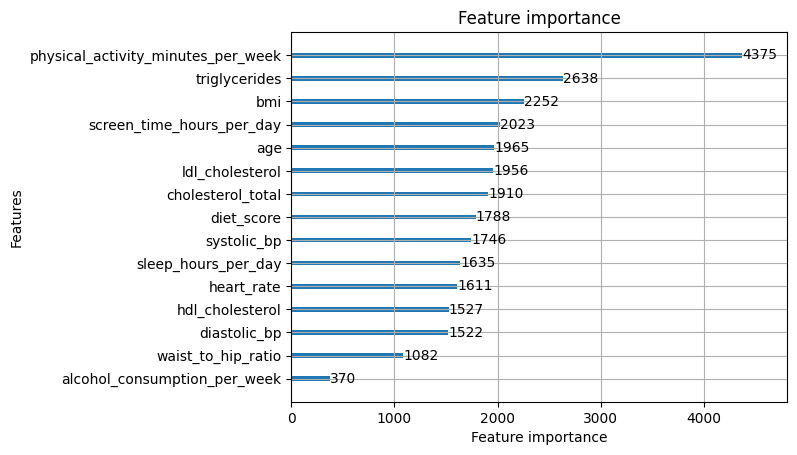

In [23]:
lgb.plot_importance(model, max_num_features=15)

In [25]:
# Predict probabilities on test set
test_pred = model.predict(test_df[feature_cols], num_iteration=model.best_iteration)

# Build submission DataFrame
lgbm_submission = pd.DataFrame({
    ID_COL: test_df[ID_COL],
    TARGET: test_pred   # probability of diagnosed_diabetes = 1
})

# Save to CSV
lgbm_submission.to_csv("lgbm_submission.csv", index=False)

In [4]:
train_df.head(2)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
